<a href="https://colab.research.google.com/github/natthanaphop-isa/options_payoff/blob/main/Payoff_Python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

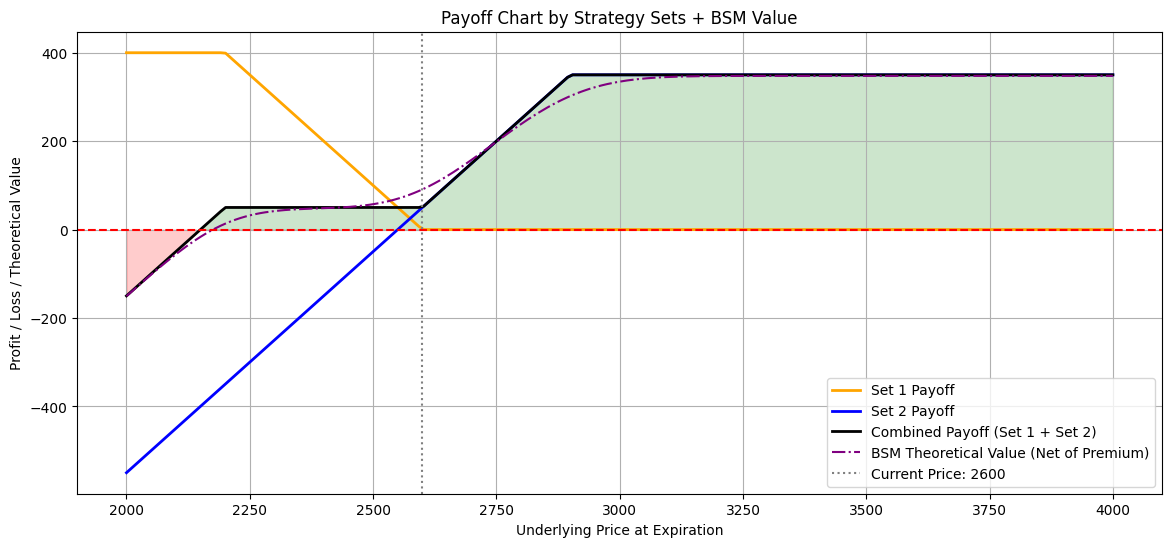

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# ==== ฟังก์ชันพื้นฐาน ====
def long_call(S, K, premium): return np.maximum(S - K, 0) - premium
def short_call(S, K, premium): return -np.maximum(S - K, 0) + premium
def long_put(S, K, premium): return np.maximum(K - S, 0) - premium
def short_put(S, K, premium): return -np.maximum(K - S, 0) + premium
def long_spot(S, entry_price): return S - entry_price
def short_spot(S, entry_price): return entry_price - S

# ==== ฟังก์ชัน BSM ====
def black_scholes_call(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r*T) * norm.cdf(d2)

def black_scholes_put(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return K * np.exp(-r*T) * norm.cdf(-d2) - S * norm.cdf(-d1)

# ==== ฟังก์ชันคำนวณ Payoff ====
def calculate_leg_payoff(S, leg):
    if leg['type'] == 'call':
        return long_call(S, leg['strike'], leg['premium']) if leg['position'] == 'long' else short_call(S, leg['strike'], leg['premium'])
    elif leg['type'] == 'put':
        return long_put(S, leg['strike'], leg['premium']) if leg['position'] == 'long' else short_put(S, leg['strike'], leg['premium'])
    elif leg['type'] == 'spot':
        return long_spot(S, leg['entry']) if leg['position'] == 'long' else short_spot(S, leg['entry'])
    else:
        return np.zeros_like(S)

# ==== ฟังก์ชันคำนวณ BSM Net of Premium ====
def calculate_leg_bsm_minus_premium(S, leg, T, r, sigma):
    if leg['type'] == 'put':
        value = black_scholes_put(S, leg['strike'], T, r, sigma)
        return value - leg['premium'] if leg['position'] == 'long' else -(value - leg['premium'])
    elif leg['type'] == 'call':
        value = black_scholes_call(S, leg['strike'], T, r, sigma)
        return value - leg['premium'] if leg['position'] == 'long' else -(value - leg['premium'])
    elif leg['type'] == 'spot':
        return long_spot(S, leg['entry']) if leg['position'] == 'long' else short_spot(S, leg['entry'])
    else:
        return np.zeros_like(S)

##### ==== กำหนดพารามิเตอร์ ==== #######
## ตัวแปร BSM ##
T = 15/365
r = 0.02
sigma = 0.20

## กรอบของกราฟ ##
current_price = 2600
Min_price_range = 2000
max_price_range = 4000

##### ============================ #######


S = np.linspace(Min_price_range, max_price_range, 200)
#####  ==== กำหนดชุดกลยุทธ์ ==== #####
set_1 = [
    {'type': 'put', 'position': 'long', 'strike': 2600, 'premium': 50},
    {'type': 'put', 'position': 'short', 'strike': 2200, 'premium': 50}
]

set_2 = [
    {'type': 'call', 'position': 'short', 'strike': 2900, 'premium': 50},
    {'type': 'spot', 'position': 'long', 'entry': 2600}
]

# ==== คำนวณผลรวมของแต่ละเซต ====
def calculate_set_payoff(option_set):
    total = np.zeros_like(S)
    for leg in option_set:
        total += calculate_leg_payoff(S, leg)
    return total

payoff_set_1 = calculate_set_payoff(set_1)
payoff_set_2 = calculate_set_payoff(set_2)
total_payoff = payoff_set_1 + payoff_set_2

# ==== คำนวณ BSM Value รวมของกลยุทธ์ทั้งหมด ====
all_legs = set_1 + set_2
bsm_total_value = np.zeros_like(S)
for leg in all_legs:
    bsm_total_value += calculate_leg_bsm_minus_premium(S, leg, T, r, sigma)

# ==== วาดกราฟ ====
plt.figure(figsize=(14,6))
plt.plot(S, payoff_set_1, label='Set 1 Payoff', color='orange', linewidth=2)
plt.plot(S, payoff_set_2, label='Set 2 Payoff', color='blue', linewidth=2)
plt.plot(S, total_payoff, label='Combined Payoff (Set 1 + Set 2)', color='black', linewidth=2)
plt.plot(S, bsm_total_value, label='BSM Theoretical Value (Net of Premium)', color='purple', linestyle='-.')

plt.fill_between(S, total_payoff, 0, where=total_payoff > 0, color='green', alpha=0.2)
plt.fill_between(S, total_payoff, 0, where=total_payoff < 0, color='red', alpha=0.2)

plt.axvline(current_price, color='gray', linestyle=':', label=f'Current Price: {current_price}')
plt.axhline(0, color='red', linestyle='--')

plt.title('Payoff Chart by Strategy Sets + BSM Value')
plt.xlabel('Underlying Price at Expiration')
plt.ylabel('Profit / Loss / Theoretical Value')
plt.grid(True)
plt.legend()
plt.show()
